In [1]:
import gym
import math
import numpy as np
from numpy import array, inf, vectorize, repeat, power
from numpy import abs as np_abs
from numpy import sum as np_sum
from scipy.special import hyp2f1
import mpmath as mp
from mpmath import fp#, hyp2f1
from numpy.random import rand
from numpy.linalg import norm
from numpy import array
from numpy import zeros, zeros_like
from numpy import ones, ones_like
from numpy import inf
from numpy import minimum, maximum
import matplotlib.pyplot as plt
import os
from stable_baselines3.sac.policies import MlpPolicy
from stable_baselines3 import SAC
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor


Main modifications:

-Introduced guess mode
When in guess mode the environment is reset to a random state. When in normal mode the environment is reset to the best state so far.

-Agent trapped
Introduced a control that terminates the episode if the agent has taken too many steps without improvement.

-Min reward capped
When the rewards get smaller than a big multiple of the best reward the episode is terminated. This should avoid divergencies in the loss. 

-Mode 2 training
Freeze scaling dimensions at the beginning of the training. 


In [2]:
def param_to_spec(param):
    # print(param)
    _A = param[::2]
    _B = param[1::2]
    output = array([(_A+spins)/2, (_A-spins)/2, _B]).transpose().flatten()
    # print(output)
    return output

def g(h, hb, z, zb):
    # h12 = ex_h[0][0] - ex_h[1][0]
    # h34 = ex_h[2][0] - ex_h[3][0]
    # hb12 = ex_h[0][1] - ex_h[1][1]
    # hb34 = ex_h[2][1] - ex_h[3][1]
    h12 = 0
    h34 = 0
    hb12 = 0
    hb34 = 0
    output = (1/2 if h == hb else 1)*(z**h*zb**hb*(hyp2f1(h-h12, h+h34, 2*h, z))*(hyp2f1(hb-hb12, hb+hb34, 2*hb, zb)) +
                                    zb**h*z**hb*(hyp2f1(h-h12, h+h34, 2*h, zb))*(hyp2f1(hb-hb12, hb+hb34, 2*hb, z)))
#     print('g=',output)
    return fp.mpc(output)


def p(h, hb, c, z, zb):
    output = c*(power(((z-1)*(zb-1)),1/8)*g(h,hb,z,zb) - power(z,1/8)*power(zb,1/8)*g(h,hb,1-z,1-zb))
#     print('p=',output)
    return output
pts = rand(29,2)

vec_p = vectorize(p, excluded=['z', 'zb'])

def e(spec, pts):
   # _A = vec_p(spec[:,0], spec[:,1], spec[:,2], pts[:,0], pts[:,1])
    #_B = ((pts[:,0]-1)*(pts[:,1]-1))**(1/8)-pts[:,0]**(1/8)*pts[:1]**(1/8)
    #output = _A + repeat(_B, len(spec))
    output=array([(np_sum(vec_p(spec[::3], spec[1::3], spec[2::3], z[0], z[1])) +
                  ((z[0]-1)*(z[1]-1))**(1/8)-z[0]**(1/8)*z[1]**(1/8)) for z in pts])
    return output


def e_abs(spec, pts):
    # _A = vec_p(spec[:, 0], spec[:, 1], spec[:, 2], pts[:, 0], pts[:, 1])
    # _B = ((pts[:, 0] - 1) * (pts[:, 1] - 1)) ** (1 / 8) - pts[:, 0] ** (1 / 8) * pts[:1] ** (1 / 8)
    # output = np_abs(np_sum(_A + repeat(_B, len(spec)), axis=1))
    # print(spec)
    output= np_abs(array([(np_sum(vec_p(spec[::3], spec[1::3], spec[2::3], z[0], z[1])) +
                  ((z[0]-1)*(z[1]-1))**(1/8)-z[0]**(1/8)*z[1]**(1/8)) for z in pts]))
#     print('e_abs=',output)
    return output

def A(spec,pts):
    output = norm(e(spec,pts))/np.sum(e_abs(spec,pts))
#     print('A=',output)
    return output

test_spec = array([[2.,2.,2.44e-4],[.5,.5,.25],[2.,0.,.016],[4.,0.,2.2e-4],[6.,0.,1.36e-5]])

spins = array([0,0,2,4,6])

class IsingEnv(gym.Env):
    
    def __init__(self, guess_mode_steps=0, trapped_steps=100, reward_cap=100, reward_scale=1.,
                 guess_size=6.5, initial_state=None, freeze_mask=None, freeze_accuracy=0.01):
        
        self.action_space = gym.spaces.Box(
            np.float32(array([-1. for i in range(10)])), np.float64(array([1. for i in range(10)]))
            )
        self.observation_space = gym.spaces.Box(
            np.float32(array([-inf for i in range(29)])),np.float64(array([inf for i in range(29)]))
            )
        self.n = 5
        self.best_reward=None  #Records best reward
        self.best_state=None   #Records best state
        self.scale=reward_scale #Scale the error
        if initial_state is not None:
                self.initial_state=initial_state
                self.state=initial_state
        else:
                self.state = rand(10)*6.5 #Added in initialization
                
        self.guess_mode=True #Controls wheter the algorithm is working in guess mode
        self.guess_mode_steps=guess_mode_steps #Number of steps to take in guess mode
        self.step_counter=0 #Records the number of steps executed in the environment
        self.not_improving_steps=0 #Stores the number of steps since last improvement
        self.trapped_steps=trapped_steps #Maximum number of not improving steps after which the environment is reset
        self.current_reward=None  #Current reward for guess mode
        self.improv_hist=[] #Records reward when a new best state is found
        self.reward_cap=reward_cap
        self.guess_size=guess_size
        self.freeze_mode=True
        self.freeze_mask=freeze_mask
        self.freeze_accuracy=freeze_accuracy
    def step(self, action):
        if self.guess_mode:
            current_obs=self._get_obs()
            current_reward=-norm(current_obs)*self.scale
            
        if self.freeze_mask is not None:#Freeze some of the parameters during training
            acc=A(param_to_spec(self.state),pts)
            if acc<self.freeze_accuracy:
                self.freeze_mode=False
            if self.freeze_mode:
                action=action*self.freeze_mask
                
        self.state=self.state+action*self.guess_size #scale the action by the guess_size
        self.state = maximum(zeros_like(self.state), self.state)
        self.state = minimum(6.5*ones_like(self.state), self.state)
        obs = self._get_obs()
        reward = -norm(obs)*self.scale
         
        if self.best_reward is None:
            self.best_reward=reward
            self.best_state=self.state

        self.step_counter+=1 #Increase step counter to control guess_mode

        if self.guess_mode:

            if self.step_counter>self.guess_mode_steps: #end guess_mode
                self.guess_mode=False
                done=True
            #check update best reward
            if reward > self.best_reward:
                self.best_reward=reward
                self.best_state=self.state
                self.improv_hist.append((self.step_counter, reward, self.state))
                self.not_improving_steps=0


            if reward>current_reward:
                done=True
            else:
                self.not_improving_steps+=1
                done=False

        else:
            #check update best reward and terminate
            if reward > self.best_reward:
                self.best_reward=reward
                self.best_state=self.state
                self.not_improving_steps=0
                self.improv_hist.append((self.step_counter, reward, self.state))
                done = True
            else:
                self.not_improving_steps+=1
                done = False
            if reward<self.reward_cap*self.best_reward: #This should limit instabilities and divergencies
                    done=True

        if self.not_improving_steps>self.trapped_steps:
                self.not_improving_steps=0
                done=True

        info = {}
        return obs, reward, done, info

    def reset(self):
        if self.guess_mode:
            #self.state = rand(10)*6.5 #reset to a random state only in guessing mode
            self.state=self.initial_state
        else:
            self.state=self.best_state
        return self._get_obs()

    def _get_obs(self):
        return e(param_to_spec(self.state),pts)

In [3]:
guess_steps=3000
total_steps=15000
trapped=100 
reward_scale=0.005
mask=np.ones(10)
mask[::2]=0.
initial_state=array([4., rand(), 1., rand(), 2., rand(), 4., rand(), 6., rand()])
search_sizes=[0.1, 1, 0.1, 1, 0.1, 1, 0.1, 1, 0.1, 1]
env=IsingEnv(guess_mode_steps=guess_steps,trapped_steps=trapped, 
             reward_scale=reward_scale, guess_size=search_sizes, initial_state=initial_state, freeze_mask=mask)
log_dir = "tmp/gym/"
os.makedirs(log_dir, exist_ok=True)
monitor=Monitor(env,log_dir)
model = SAC(MlpPolicy,monitor, verbose=1, device='cuda')
model.learn(total_timesteps=total_steps, log_interval=100)

Using cpu device
Wrapping the env in a DummyVecEnv.


C:\Users\Gabriele\.conda\envs\tf-gpu\lib\site-packages\stable_baselines3\common\vec_env\dummy_vec_env.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  self.buf_obs[key][env_idx] = obs
C:\Users\Gabriele\.conda\envs\tf-gpu\lib\site-packages\stable_baselines3\common\buffers.py:239: ComplexWarning: Casting complex values to real discards the imaginary part
  self.next_observations[self.pos] = np.array(next_obs).copy()


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.06     |
|    ep_rew_mean     | -22.8    |
| time/              |          |
|    episodes        | 100      |
|    fps             | 12       |
|    time_elapsed    | 16       |
|    total timesteps | 206      |
| train/             |          |
|    actor_loss      | 132      |
|    critic_loss     | 3.28e+03 |
|    ent_coef        | 1.03     |
|    ent_coef_loss   | -2.07    |
|    learning_rate   | 0.0003   |
|    n_updates       | 105      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.96     |
|    ep_rew_mean     | -23.2    |
| time/              |          |
|    episodes        | 200      |
|    fps             | 9        |
|    time_elapsed    | 42       |
|    total timesteps | 402      |
| train/             |          |
|    actor_loss      | 162      |
|    critic_loss     | 7.7e+03  |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | -0.364   |
| time/              |          |
|    episodes        | 1600     |
|    fps             | 6        |
|    time_elapsed    | 351      |
|    total timesteps | 2311     |
| train/             |          |
|    actor_loss      | 95.5     |
|    critic_loss     | 2.37e+03 |
|    ent_coef        | 1.79     |
|    ent_coef_loss   | -28.1    |
|    learning_rate   | 0.0003   |
|    n_updates       | 2210     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.01     |
|    ep_rew_mean     | -0.547   |
| time/              |          |
|    episodes        | 1700     |
|    fps             | 6        |
|    time_elapsed    | 368      |
|    total timesteps | 2412     |
| train/             |          |
|    actor_loss      | 131      |
|    critic_loss     | 2.39e+03 |
|    ent_coef 

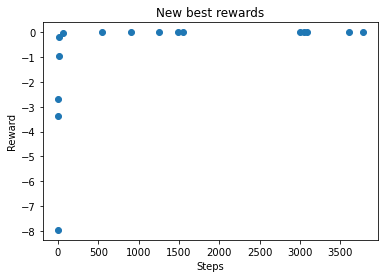

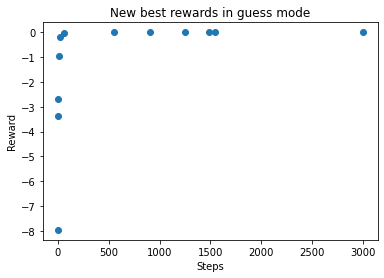

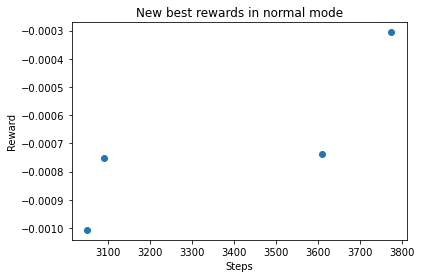

In [4]:
steps=[]
rew=[]
for el in env.improv_hist:
        steps.append(el[0])
        rew.append(el[1])
        
plt.scatter(steps,rew)
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title('New best rewards')
plt.show()

min_index=len(rew)
for i,step in enumerate(steps):
        if step>guess_steps:
                min_index=i
                break
                
plt.scatter(steps[:min_index],rew[:min_index])
plt.title('New best rewards in guess mode')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.show()
plt.scatter(steps[min_index:],rew[min_index:])
plt.title('New best rewards in normal mode')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.show()

Improvements in the later stages seem very sparse. 

In [5]:
print('Number of improvements:', len(rew))
print('Lowest error:', env.best_reward*(1/reward_scale))
print('Best state:', env.best_state)

Number of improvements: 16
Lowest error: -0.06118595811693286
Best state: [4.         0.         1.         0.26839459 2.         0.01686859
 4.         0.         6.         0.        ]


In [6]:
 print('Accuracy', A(param_to_spec(env.best_state),pts))

Accuracy 0.2124090274335056


In [7]:
print('Initial state:', initial_state)

Initial state: [4.         0.11832039 1.         0.86040599 2.         0.80824716
 4.         0.301693   6.         0.73923346]


In [8]:
true_state=array([4, 2.44141e-4, 1, 0.25, 2, 0.015625, 4, 2.19727e-4, 6, 1.36239e-5])
print('True state accuracy (check)', A(param_to_spec(true_state), pts))
print('True state error', norm(e(param_to_spec(true_state),pts)))

True state accuracy (check) 0.3904961036525475
True state error 0.0023209387345166244


Is there some problem with accuracy and error? They are not 0 for the true state...

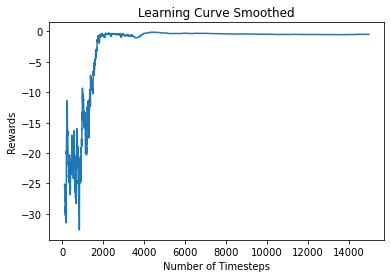

ValueError: v cannot be empty

In [9]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

def plot_results(log_folder, start=0, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = results_plotter.ts2xy(results_plotter.load_results(log_folder), 'timesteps')
    x=x[start:]
    y=y[start:]
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()
    
plot_results(log_dir)
plot_results(log_dir, start=guess_steps) #Plot only results after guess mode

In [ ]:
results_plotter.plot_results([log_dir], None, results_plotter.X_TIMESTEPS, "Ising SAC")
plt.show()

In [ ]:
print(rand())